# Notebook on cracking geetest CAPTCHA 
# This Notebook is for educational only
# Author: Joe Ho
# Date: 5, January, 2020

## Import Library

In [1]:
import cv2
import time
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint

from scipy import ndimage, misc
from scipy.spatial.distance import hamming

import pandas as pd

from selenium import webdriver

from auxiliary_function import segment_pictures

In [2]:
# # Uncomment this part for real Geetest CAPTCHA


# image_path = ".//image//"+str(time.time())+".jpg"

# driver = webdriver.Chrome() 

# # driver.get("https://www.geetest.com/en")  # Old Path
# driver.get("https://www.geetest.com/show")  

In [3]:
# # Uncomment this part for real Geetest CAPTCHA


# time.sleep(10)
# img = driver.find_element_by_class_name("geetest_item_img")
# src = img.get_attribute('src')

# # download the image
# urllib.request.urlretrieve(src, image_path)

In [4]:
# # Comment this part for real Geetest CAPTCHA
image_path = "dataset/img/1.jpg" 

## Load geetest Image

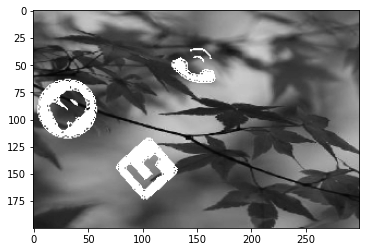

In [5]:
img_grey = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_grey, cmap="gray")

## Icons filter

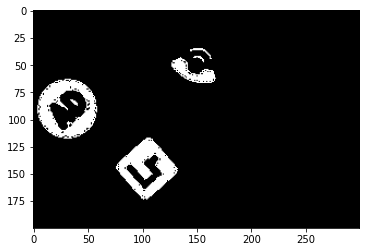

In [6]:
# Image preprocessing

color_threshold = 220
main_pane = img_grey # cv2.blur(img_grey,(3,3)) # By blurring, we can remove some white pixels which may affecting the matching
main_pane[main_pane<color_threshold] = 0
main_pane[main_pane>=color_threshold] = 255
plt.imshow(main_pane, cmap="gray")

## Locate icons

In [7]:
def find_bounding_box(pane, bounding_box_lower_thresholds, bounding_box_upper_thresholds, sort=True):
    # thresholds: turple
    # dimension_resized: turple
    
    segmented_pictures = []
    rect_coordinates = []
    
    
    width_lower_threshold, height_lower_threshold = bounding_box_lower_thresholds
    width_upper_threshold, height_upper_threshold = bounding_box_upper_thresholds
    
    contours, hierarchy = cv2.findContours(pane, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if h > height_lower_threshold and w > width_lower_threshold and h <= height_upper_threshold and w <= width_upper_threshold:
            rect_coordinates.append((x, y, w, h))
        
        else:
            continue 
    if sort:
        x_coordinates = [x for (x,y,w,h) in rect_coordinates]
        rect_coordinates= [e for _,e in sorted(zip(x_coordinates,rect_coordinates))]
    return rect_coordinates


In [8]:
icons_rect_coordinates = find_bounding_box(main_pane, (20,20), (100,100),sort=False)
icons = segment_pictures(main_pane,icons_rect_coordinates,(30,30))

In [9]:
def draw_bounding_box(pane, rect_coordinates):
    # Show bounding boxes

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(pane, cmap="gray")

    # Create a Rectangle patch
    for e in rect_coordinates:
        (x, y, w, h) = e
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

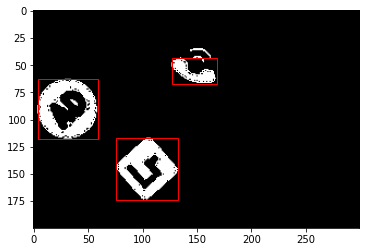

In [10]:
draw_bounding_box(main_pane, icons_rect_coordinates)    

## Load targets

In [11]:
csv = pd.read_csv('dataset/data.csv', delimiter=',', header=None)
icons_name = csv.loc[0,1:]
icons_path = [f'dataset/icon/{icon_name}.png' for icon_name in icons_name]
icons_path

['dataset/icon/ad.png',
 'dataset/icon/phone-call.png',
 'dataset/icon/adobe-lightroom.png']

In [12]:
def filter_correct_channel(img):
    if (img[:, :, 0] > 0).any(): return 255 - img[:, :, 0] #B
    if (img[:, :, 1] > 0).any(): return 255 - img[:, :, 1] #G
    if (img[:, :, 2] > 0).any(): return 255 - img[:, :, 2] #R
    return img[:, :, 3]

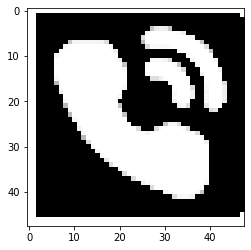

In [16]:
ad_icon = cv2.imread('dataset/icon/phone-call.png', cv2.IMREAD_UNCHANGED)
ad_icon = filter_correct_channel(ad_icon)
plt.imshow(ad_icon, cmap="gray")

def read_and_preprocess_icon(icon_path):
    icon = cv2.imread(icon_path, cv2.IMREAD_UNCHANGED)
    return filter_correct_channel(icon)

In [ ]:
icons = [read_and_preprocess_icon(icon_path) for icon_path in icons_path]

## Locat the most similiar icon in main pane for each target

In [14]:
# Rotate the icon by d degree each time and calculate the similarity between icon and target
def calculate_max_matching(target,icon,d):
    largest_val = 0
    for degree in range(0,360,d):
        tmp = ndimage.rotate(target, degree, reshape=False)
        res = cv2.matchTemplate(icon,tmp,cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > largest_val:
            largest_val = max_val
    return largest_val

In [15]:
# Calculate similarity matrix for each target, icon pair
'''
similarity_matrix = [[a1, a2, a3, a4, a5],
                     [b1, b2, b3, b4, b5],
                     [c1, c2, c3, c4, c5],
                     [d1, d2, d3, d4, d5],
                    ]
                    
There are 4 targets and 5 icons, so it is 4x5 matrix. For example, b3 denotes the similarity between second target and
third icon
'''

similarity_matrix = []
for target in targets:
    similarity_per_target = []
    for icon in icons:
        similarity_per_target.append(calculate_max_matching(target,icon,6))
    similarity_matrix.append(similarity_per_target)

NameError: name 'targets' is not defined

In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(main_pane)

# Calculate Mapping
target_candidates = [False for _ in range(len(targets))]
icon_candidates = [False for _ in range(len(icons))]

mapping = {}

# Approach 1 (May not work, because collision may occur)
# Using np.argsort(-arr)

'''
similarity_matrix = [[0.49798074, 0.61611921, 0.56135607, 0.43419564, 0.61747766],
                     [0.5085994 , 0.53169155, 0.70087528, 0.30092609, 0.53550088],
                     [0.62834615, 0.49904037, 0.46511394, 0.31213483, 0.46880326],
                     [0.53429979, 0.59877342, 0.56217539, 0.37746215, 0.73305559]]


np.argsort(np.array(similarity_matrix),axis=1) = [[3, 0, 2, 1, 4],
                                                  [3, 0, 1, 4, 2],
                                                  [3, 2, 4, 1, 0],
                                                  [3, 0, 2, 1, 4]]

In this approach, 
First target matches with fifth icon
Second target matches with second icon
Third target matches with fist icon
Fourth target matches with fifth icon

Collision happens! As both first target and fourth target matches the same icon
'''


# Sort the flatted similarity matrix in descending order, and assign the pair between target and icon if both of them
# havem't been assigned.
arr = np.array(similarity_matrix).flatten()
arg_sorted = np.argsort(-arr)

for e in arg_sorted:
    col = e //len(icons)
    row = e % len(icons)
    
    if target_candidates[col] == False and icon_candidates[row] == False:
        target_candidates[col], icon_candidates[row] = True, True
        mapping[col] = row

# Circling the most similar icon,
# blue circle: first target
# red circle: second target
# yellow circle: third target
# green circle: fourth target
color_map = {1:'b',2:'r',3:'y',4:'g'}
for key in mapping:
    x,y,w,h = icons_rect_coordinates[mapping[key]]
    
    # x,y is the coordinate of top left hand corner
    # Bounding box is 70x70, so centre of circle = (x+70/2, y+70/2), i.e. (x+35, y+35)
    centre_x = x+(w//2)
    centre_y = y+(h//2)
    # Plot circle
    circle = plt.Circle((centre_x,centre_y), 20, color=color_map[key+1], fill=False, linewidth=5)
    # Plot centre
    plt.plot([centre_x], [centre_y], marker='o', markersize=10, color="white")
    ax.add_patch(circle)
     
plt.show()

In [ ]:
# blue circle: first target
# red circle: second target
# yellow circle: third target
# green circle: fourth target
plt.imshow(img_grey) 

## Click targets

In [ ]:
# # Uncomment this part for real Geetest CAPTCHA


# time.sleep(10)
# for i, target in enumerate(targets):
#     key = i
#     x,y,w,h = icons_rect_coordinates[mapping[key]]
    
#     # x,y is the coordinate of top left hand corner
#     # Bounding box is 70x70, so centre of circle = (x+70/2, y+70/2), i.e. (x+35, y+35)
#     centre_x = x+(w//2)
#     centre_y = y+(h//2)
    
#     ele=driver.find_element_by_xpath(u"(.//*[normalize-space(text()) and normalize-space(.)='加载中...'])[1]/following::div[1]")
#     action = webdriver.common.action_chains.ActionChains(driver)
#     action.move_to_element_with_offset(ele, centre_x, centre_y)
#     time.sleep(randint(100,700)/1000) # Random Pause between two consecutive clicks
#     action.click()
#     action.perform()

# # Click Ok button in CAPTCHA after some random pause
# time.sleep(randint(100,700)/1000)
# driver.find_element_by_xpath(u"(.//*[normalize-space(text()) and normalize-space(.)='帮助反馈'])[1]/following::div[2]").click()    